# Machine Learning on Seismic Data (Classification & Clustering)

Applying basic ML methods on seismic waveform data. This builds on the previous analysis where I used STA/LTA to detect events. Now, I’ll extract features from the waveform and use ML to:

- Classify seismic windows as 'event' or 'no-event'
- Cluster similar waveform segments to identify patterns

The seismic data is retrieved from the IRIS database, filtered and processed, and then used to train and evaluate ML models.

**Signal processing & ML on numeric time-series data  
Supervised classification, unsupervised clustering using scikit-learn**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
#using same station data from previous notebook 9 
client = Client("IRIS")
starttime = UTCDateTime("2010-02-27T06:30:00")
endtime = starttime + 10 * 60  # 10 minutes

st = client.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                          starttime=starttime, endtime=endtime)

st.detrend("linear")
st.filter("bandpass", freqmin=0.5, freqmax=5.0)

tr = st[0]

# to detect events
nsta = int(1 * tr.stats.sampling_rate)
nlta = int(20 * tr.stats.sampling_rate)

cft = classic_sta_lta(tr.data, nsta, nlta)
on_thresh, off_thresh = 3.5, 0.5
trig_onsets = trigger_onset(cft, on_thresh, off_thresh)



In [5]:
#Slicing the window and feature extraction
window_size = int(10 * tr.stats.sampling_rate)  # 10-second windows
step_size = int(5 * tr.stats.sampling_rate)     # 5-second step

features = []
labels = []

for start in range(0, len(tr.data) - window_size, step_size):
    window = tr.data[start:start + window_size]
    timeslice = tr.times()[start:start + window_size]
    
    # Extract simple features
    feat = [
        np.mean(window),
        np.std(window),
        np.max(window),
        np.min(window),
        np.sum(window**2),                  # energy
        np.count_nonzero(np.diff(np.sign(window)))  # zero crossings
    ]
    
    features.append(feat)
    
    # Label as event (1) if this window overlaps a detected event
    label = 0
    for onset in trig_onsets:
        if onset[0] < start + window_size and onset[1] > start:
            label = 1
            break
    labels.append(label)

X = np.array(features)
y = np.array(labels)


## Machine Learning on Seismic Data

In this section, I explored the use of basic machine learning models to identify patterns in seismic data.

- **Supervised Learning (Classification)**: I used a classifier to learn from labeled seismic signals and predict whether a signal is an earthquake or noise. This method relies on historical data with known outcomes.

- **Unsupervised Learning (Clustering)**: Using KMeans clustering, I grouped similar seismic signals without any labels. This technique helps uncover hidden patterns or new types of seismic events.

These visualizations help demonstrate how machine learning can assist in analyzing and automating seismic event detection.

**Classification**  
training a sample classifier

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        25
           1       0.67      0.55      0.60        11

    accuracy                           0.78        36
   macro avg       0.74      0.71      0.72        36
weighted avg       0.77      0.78      0.77        36

[[22  3]
 [ 5  6]]


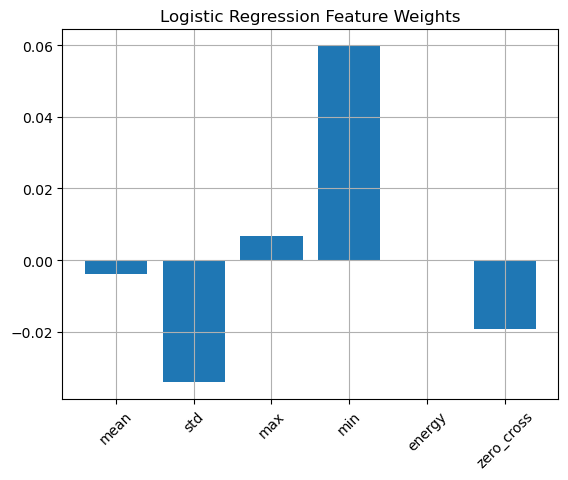

In [7]:
#visualising (Rudimentary)
plt.bar(range(len(clf.coef_[0])), clf.coef_[0])
plt.xticks(range(len(clf.coef_[0])), ['mean', 'std', 'max', 'min', 'energy', 'zero_cross'], rotation=45)
plt.title("Logistic Regression Feature Weights")
plt.grid(True)
plt.show()


**Clustering (Unsupervisied)

C:\Users\saijy\conda\envs\seismic_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\saijy\conda\envs\seismic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


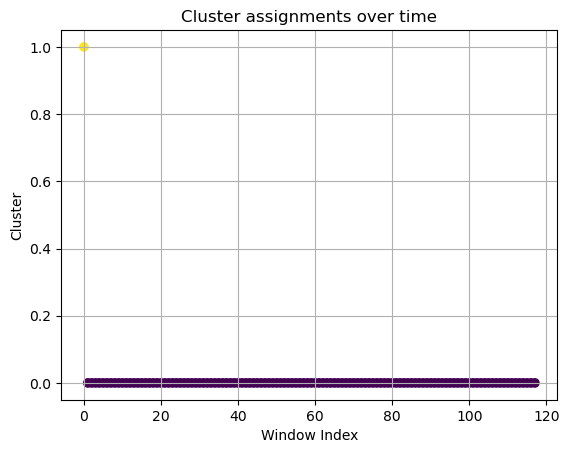

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X)

# Compare cluster assignment with labels
plt.scatter(range(len(clusters)), clusters, c=clusters, cmap='viridis', label='Cluster ID')
plt.title("Cluster assignments over time")
plt.xlabel("Window Index")
plt.ylabel("Cluster")
plt.grid(True)
plt.show()
